<a href="https://colab.research.google.com/github/luisashimabucoro/NMA-Project-Code-Summarization/blob/main/Code2Doc_usingGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preliminaries**

In [1]:
!pip install transformers &> /dev/null

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import io
import re
import math
import random
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from tqdm.notebook import tqdm
from sklearn.utils import shuffle


import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
# mount gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Basic EDA**

In [3]:
data_df = pd.read_json('/content/gdrive/Shareddrives/Dolma2/Datasets/python/train.jsonl', lines=True)

In [4]:
len(data_df) # samples

251820

In [5]:
train_df = data_df.loc[:,['code_tokens', 'docstring_tokens']] # removing extra columns
train_df

,code_tokens,docstring_tokens
0,"[def, split_phylogeny, (, p, ,, level, =, ""s"",...","[Return, either, the, full, or, truncated, ver..."
1,"[def, ensure_dir, (, d, ), :, if, not, os, ., ...","[Check, to, make, sure, the, supplied, directo..."
2,"[def, file_handle, (, fnh, ,, mode, =, ""rU"", )...","[Takes, either, a, file, path, or, an, open, f..."
3,"[def, gather_categories, (, imap, ,, header, ,...","[Find, the, user, specified, categories, in, t..."
4,"[def, parse_unifrac, (, unifracFN, ), :, with,...","[Parses, the, unifrac, results, file, into, a,..."
...,...,...
251815,"[def, setCachedDataKey, (, engineVersionHash, ...","[Sets, the, cached, data, value, for, the, spe..."
251816,"[def, writeFile, (, filename, ,, data, ), :, w...","[Writes, data, to, a, file]"
251817,"[def, patchFile, (, filename, ,, replacements,...","[Applies, the, supplied, list, of, replacement..."
251818,"[def, escapePathForShell, (, path, ), :, if, p...","[Escapes, a, filesystem, path, for, use, as, a..."


In [6]:
# list(train_df['docstring_tokens']" ".join())
for i in train_df['docstring_tokens']:
  j = " ".join(i)
  print(j)
  break

Return either the full or truncated version of a QIIME - formatted taxonomy string .


In [7]:
docstring = list(train_df['docstring_tokens'].apply(lambda x: " ".join(x)))
code = list(train_df['code_tokens'].apply(lambda x: " ".join(x)))
combined = []
for i, x in enumerate(docstring):
  pair = []
  pair.append(docstring[i])
  pair.append(code[i])
  combined.append(pair)
  print(combined)
  break

[['Return either the full or truncated version of a QIIME - formatted taxonomy string .', 'def split_phylogeny ( p , level = "s" ) : level = level + "__" result = p . split ( level ) return result [ 0 ] + level + result [ 1 ] . split ( ";" ) [ 0 ]']]


In [8]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
    self.n_words = 3  # Count SOS and EOS and PAD

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1


def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )


def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s


def readLangs(lang1, lang2, data, reverse=False):
  print("Reading lines...")

  docstring = list(train_df['docstring_tokens'].apply(lambda x: " ".join(x)))
  code = list(train_df['code_tokens'].apply(lambda x: " ".join(x)))
  combined = []
  for i, x in enumerate(docstring):
    pair = []
    pair.append(docstring[i])
    pair.append(code[i])
    combined.append(pair)
    #print(combined[:5])
  '''
  # Read the file and split into lines
  lines = io.open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
  print(pairs[-5:])

  train_df
  '''

  # Reverse pairs, make Lang instances
  if reverse:
      pairs = [list(reversed(p)) for p in combined]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
  else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)
  print(combined)
  return input_lang, output_lang, combined

In [9]:
MAX_LENGTH = 1000

def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
      len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]



In [10]:
def prepareData(lang1, lang2, data, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, data, reverse)
  print(pairs)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('cod', 'des', train_df, True)
print(pairs)

Reading lines...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
def plot_lang(lang, top_k=100):
  words = list(lang.word2count.keys())
  words.sort(key=lambda w: lang.word2count[w], reverse=True)
  print(words[:top_k])
  count_occurences = sum(lang.word2count.values())

  accumulated = 0
  counter = 0

  while accumulated < count_occurences * 0.8:
    accumulated += lang.word2count[words[counter]]
    counter += 1

  print(f"The {counter * 100 / len(words)}% most common words "
        f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
  plt.bar(range(100), [lang.word2count[w] for w in words[:top_k]])
  plt.show()

['.', 'the', 'a', 'to', 'of', 'and', 'for', 'in', 'from', 'is', 'an', '-', 'given', 'with', 'if', 'that', 'Return', 'file', 'all', 'this', 'Returns', 'list', 'or', 'on', 'by', 'data', 'be', 'as', 'object', 'it', 'Get', 'function', 'value', 'string', 'into', 'return', 'are', 'name', 's', 'new', 'not', 'specified', 'Create', 'This', 'method', 'will', 'set', 'current', 'returns', 'user', 'values', 'If', 'using', 'path', 'The', 'one', 'instance', 'key', 'each', 'at', 'Add', 'type', 'which', 'dictionary', 'number', 'used', 'can', 'request', 'files', 'message', 'Set', 'model', 'based', 'any', 'its', 'Check', 'Convert', 'command', 'when', 'time', 'node', 'input', 'class', 'dict', 'has', 'directory', 'text', 'information', 'single', 'default', 'line', 'only', 'state', 'Creates', 'output', 'format', 'A', 'objects', 'version', 'configuration']
The 1.476028981039001% most common words account for the 80.00089637643329% of the occurrences


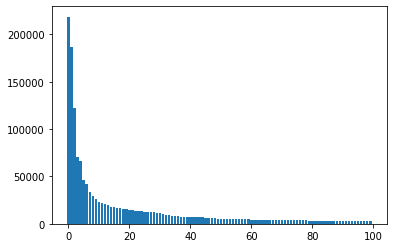

In [12]:
plot_lang(input_lang)

['(', ')', '.', ',', '=', ':', 'self', '[', ']', 'if', 'return', 'def', 'in', 'None', 'for', 'not', '0', '1', 'else', '+', '==', 'is', 'name', 'raise', 'data', '-', 'path', '{', '}', '*', 'True', 'False', 'format', 'value', 'and', 'len', 'append', 'get', 'key', 'i', '%', '**', 'kwargs', 'args', 'except', 'np', 'try', 'os', 'x', 'elif', 'isinstance', 'or', 'str', '2', 'result', "'", 'join', '+=', 'as', '"', 'to', 'a', 'f', '', 'int', 'with', '!=', 'k', 'e', 'ValueError', 'cls', 'v', 'list', '>', 'response', 'request', 'ret', 'logger', 'line', 'url', "''", '/', 'debug', 'print', 'config', 'obj', 'params', 's', 'info', 'log', 'index', 'filename', 'type', 'msg', 'node', 'items', 'split', 'r', 'p', 'text']
The 0.1337243917266665% most common words account for the 80.00199674473694% of the occurrences


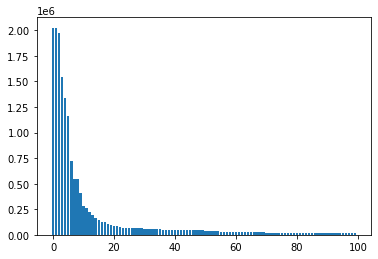

In [13]:
plot_lang(output_lang)

In [14]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

  def forward(self, input, hidden):
    embedded = self.embedding(input)#.view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self, batch_size):
    return torch.zeros(1, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, input, hidden):
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

def to_train(input_lang, output_lang, pairs, max_len=MAX_LENGTH+2):
  x_input = []
  x_output = []
  target = []
  for i, o in pairs:
    s_i = [2] * max_len + [0] + [input_lang.word2index[w] for w in i.split(" ")] + [1]
    s_o = [0] + [output_lang.word2index[w] for w in o.split(" ")] + [1] + [2] * max_len
    s_to = s_o[1:] + [2]
    x_input.append(s_i[-max_len:])
    x_output.append(s_o[:max_len])
    target.append(s_to[:max_len])
  return x_input, x_output, target

In [15]:
x_input, x_partial, y = to_train(input_lang, output_lang, pairs)

In [16]:
print('Representation of an input sentece:')
print(x_input[0])
print(' '.join([input_lang.index2word[w] for w in x_input[0]]))
print('\nRepresentation of an partial sentece:')
print(x_partial[0])
print(' '.join([output_lang.index2word[w] for w in x_partial[0]]))
print('\nRepresentation of an target sentece:')
print(y[0])
print(' '.join([output_lang.index2word[w] for w in y[0]]))

Representation of an input sentece:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [17]:
def predict(encoder, decoder, input, output):
  _, hidden = encoder(input, encoder.initHidden(input.shape[0]))
  out, _ = decoder(output, hidden)
  return out

def train(encoder, decoder, loss, input, output, target, learning_rate=0.001, epochs=10, batch_size=100):

  plot_losses = []
  plot_full_losses = []

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

  for _ in tqdm(range(epochs)):
    c_input, c_output, c_target = shuffle(input, output, target)
    c_input = torch.tensor(c_input, dtype=torch.long, device=device)
    c_output = torch.tensor(c_output, dtype=torch.long, device=device)
    c_target = torch.tensor(c_target, dtype=torch.long, device=device)
    acc_loss = 0
    for i in range(0, c_target.shape[0], batch_size):
      c_batch_size = c_target[i:i+batch_size, ...].shape[0]
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      out = predict(encoder, decoder, c_input[i:i+batch_size, ...], c_output[i:i+batch_size, ...])
      #Reshapes the output and target to use the expected loss format.
      # N x Classes for the output
      # N for the targets
      # Where N is the batch size
      out = out.reshape(c_batch_size * c_input.shape[1], -1)
      r_target = c_target[i:i+batch_size, ...].reshape(c_batch_size * c_input.shape[1])

      c_loss = loss(out, r_target)
      # Mask the errors for padding as they are not usefull!
      valid = torch.where(r_target == 2, 0, 1)
      c_loss = c_loss * valid
      c_loss = torch.sum(c_loss) #/ torch.sum(valid)

      c_loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()
      plot_full_losses.append(c_loss.detach().cpu().numpy())
      acc_loss += c_loss.detach().cpu().numpy()
    plot_losses.append(acc_loss /math.ceil(c_target.shape[0] / batch_size))
  return plot_losses, plot_full_losses

In [ ]:
hidden_size = 300
num_epochs = 10  # Change this to 50 (original value!)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
epoch_error, batch_error = train(encoder, decoder,
                                 nn.NLLLoss(reduction='none'),
                                 x_input, x_partial, y,
                                 epochs=num_epochs)

In [ ]:
#print(epoch_error)
#print(batch_error)

plt.plot(batch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('minibatch')
plt.show()

plt.plot(epoch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
p = predict(encoder, decoder, torch.tensor([x_input[100]],
                                           dtype=torch.long,
                                           device=device),
            torch.tensor([x_partial[100]], dtype=torch.long, device=device))

p = p.detach().numpy()

In [ ]:
print(np.argmax(p, axis=-1))
print(x_partial[40])